In [49]:
import config
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from operator import attrgetter
import datetime as dt
import seaborn as sns
import scipy.optimize
import math

In [50]:
# TODO: These names are already used in least_squares_criterion
N, I0, R0, S0, downloads_per_month, average_infection_rate, alpha, beta, t_start_milliseconds = attrgetter('N', 'I0', 'R0', 'S0', 'downloads_per_month', 'average_infection_rate', 'alpha', 'beta', 't_start_milliseconds')(config.FACEBOOK_SIR_CONSTANTS)

In [51]:
def convert_quarter_to_timestamp_milliseconds(quarter_str: str) -> float:
    quarter_index, year = map(int, quarter_str[1:].split())
    month = quarter_index * 3 - 2
    date = dt.datetime(year, month, 1)
    return date.timestamp() * 1000

mau = pd.read_csv(config.DATA_DIR / 'facebook_quarterly_monthly_active_users.csv')
mau['timestamp_milliseconds'] = mau['quarter'].apply(convert_quarter_to_timestamp_milliseconds)
I_real = mau['MAU']

In [52]:
t_step = 1e-1
t_start = 0
t_end = t_step * math.ceil(((list(mau['timestamp_milliseconds'])[-1] - t_start_milliseconds) / config.MILLISECONDS_IN_MONTH) / t_step)

wanted_months = (mau['timestamp_milliseconds'] - t_start_milliseconds) / config.MILLISECONDS_IN_MONTH

def get_nearest_indices(wanted_month):
    return {
        'lower_index': int(t_step * math.floor(wanted_month / t_step)),
        'upper_index': int(t_step * math.ceil(wanted_month / t_step)),
        'wanted_month': wanted_month,
    }

indices_month = np.vectorize(get_nearest_indices)(wanted_months)

In [57]:
def least_squares_criterion(theta):
    S0, I0, R0, alpha, beta = theta
    N = S0 + I0 + R0

    n_steps = int(1 + (t_end - t_start) / t_step) # FIXME:
    # error if (t_end - t_start) // t_step =/= int
    t_arr = np.linspace(t_start, t_end, n_steps, endpoint=True)

    S_arr = np.zeros(n_steps)
    I_arr = np.zeros(n_steps)

    S_arr[0] = S0
    I_arr[0] = I0

    for n, _ in enumerate(t_arr[:-1]):
        S_arr[n + 1] = S_arr[n] + t_step * (-alpha / N * S_arr[n] * I_arr[n])
        I_arr[n + 1] = I_arr[n] + t_step * (alpha / N * S_arr[n] * I_arr[n] - beta * I_arr[n])

    def get_interpolated_I(indices_month_obj):
        I1 = I_arr[indices_month_obj['lower_index']]
        I2 = I_arr[indices_month_obj['upper_index']]
        t1 = t_arr[indices_month_obj['lower_index']]
        dI = I2 - I1
        dt = t_step
        rc = dI / dt
        t = indices_month_obj['wanted_month'] - t1
        I_interpolated = I1 + rc * t
        return I_interpolated
    
    I_estimate = np.vectorize(get_interpolated_I)(indices_month)

    return np.sum((I_real - I_estimate) ** 2)

max_population_count = 9 * 10**9
theta_bounds = scipy.optimize.Bounds(lb=(0, 0, 0, 0, 0), ub=(max_population_count, max_population_count, max_population_count, np.inf, np.inf))
theta_guess = (S0, I0, R0, alpha, beta)
result: scipy.optimize.OptimizeResult = scipy.optimize.minimize(fun=least_squares_criterion, x0=theta_guess, method='nelder-mead', bounds=theta_bounds, options={
    # TODO: explain choices xatol and fatol
    # 'xatol': min(1, 1e-5),
    # 'fatol': 25 * (1e5 / 25) ** 2,
    # 'fatol': 1e4,
    'xatol': 1e18,
    'fatol': 1e13,
    'disp': True,
    'maxiter': 1e5,
    'maxfev': 1e5,
})

print(f'{result.success=}')
print(f'{result.status=}')
print(f'{result.message=}')
print(f'{result.nit=}')
print(f'{result.nfev=}')
theta_estimate = result.x

Optimization terminated successfully.
         Current function value: 615334843506331392.000000
         Iterations: 265
         Function evaluations: 426
result.success=True
result.status=0
result.message='Optimization terminated successfully.'
result.nit=265
result.nfev=426


In [58]:
val1 = 615325375130527104.000000
# val1 = 615325375130518912.000000
val2 = 615325375130518272.000000
np.abs(val1 - val2)

8832.0

In [59]:
S0, I0, R0, alpha, beta = theta_estimate
N = S0 + I0 + R0

n_steps = int(1 + (t_end - t_start) / t_step) # FIXME:
# error if (t_end - t_start) // t_step =/= int
t_arr = np.linspace(t_start, t_end, n_steps, endpoint=True)

S_arr = np.zeros(n_steps)
I_arr = np.zeros(n_steps)

S_arr[0] = S0
I_arr[0] = I0

for n, t_n in enumerate(t_arr[:-1]):
    S_arr[n + 1] = S_arr[n] + t_step * (-alpha / N * S_arr[n] * I_arr[n])
    I_arr[n + 1] = I_arr[n] + t_step * (alpha / N * S_arr[n] * I_arr[n] - beta * I_arr[n])

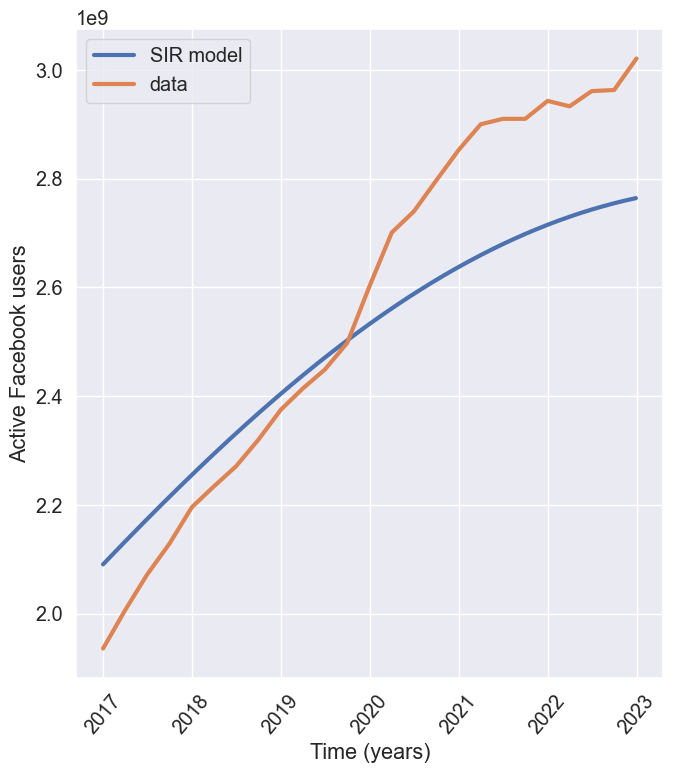

In [60]:
FIGURE_WIDTH = 7
FIGURE_HEIGHT = 8
LINEWIDTH = 3
FONT_SCALE = 1.3

MAX_TIMESTAMP_MILLISECONDS = dt.datetime(2023, 1, 1).timestamp() * 1000

t_arr_milliseconds = t_arr * config.MILLISECONDS_IN_MONTH + t_start_milliseconds
sir_model = pd.DataFrame({
    'I': I_arr,
    'timestamp_milliseconds': t_arr_milliseconds,
})
sir_model_cutoff = sir_model.loc[sir_model['timestamp_milliseconds'] <= MAX_TIMESTAMP_MILLISECONDS]
mau_cutoff = mau.loc[mau['timestamp_milliseconds'] <= MAX_TIMESTAMP_MILLISECONDS]

sns.set_theme()
sns.set(font_scale=FONT_SCALE) # TODO: REFACTOR
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

sns.lineplot(data=sir_model_cutoff, x='timestamp_milliseconds', y='I', label='SIR model', linewidth=LINEWIDTH)
sns.lineplot(data=mau_cutoff, x='timestamp_milliseconds', y='MAU', label='data', linewidth=LINEWIDTH)

def convert_year_to_timestamp_milliseconds(year: int) -> float:
    return dt.datetime(year, 1, 1).timestamp() * 1000

def format_timestamp_milliseconds(timestamp_milliseconds: float) -> str:
    datetime_obj = dt.datetime.fromtimestamp(timestamp_milliseconds / 1000)
    return datetime_obj.strftime('%Y')

years = list(range(2017, 2023 + 1)) # TODO: refactor met MAX_TIMESTAMP_MILLISECONDS
xticks = list(map(convert_year_to_timestamp_milliseconds, years))
xlabels = list(map(format_timestamp_milliseconds, xticks))

ax = plt.gca()
ax.set_xticks(xticks, xlabels, rotation=50)

plt.xlabel('Time (years)')
plt.ylabel('Active Facebook users')

plt.tight_layout()
plt.savefig(config.FIGURES_DIR / 'basic_facebook_sir_model_fitted_parameters.svg')
plt.show()